# Modélisation

### Import des modules et du fichier nettoyé

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from projet_3_struct.funcs import (
    Multi_usage,
    Categorie_anne_construction,
    Categorie_nb_etage,
    Categorie_nb_batiment,
    calcul_part_habitation,
)

from scipy import stats

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error ,mean_absolute_percentage_error, root_mean_squared_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn


In [50]:
building_consumption = pd.read_csv("building_consumption_pour_analyses.csv")

del building_consumption["Conso_elec_mesure"]

In [51]:
target = "SiteEnergyUseWN(kBtu)_ajuste"

# les variables prédictives

X = building_consumption.drop(columns=[target])

# la variable cible

y = building_consumption[target]

X.head()

,PropertyGFATotal,PropertyGFAParking,Conso_gaz_mesure,Emission_steam_mesure,Groupe_anne_construction_label,Groupe_nb_etages_label,Groupe_nb_batiments_label,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,BuildingType_SPS-District K-12,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Usage_multiple_Mono usage,Usage_multiple_Multi usage
0,88434,0,1,1,0,2,0,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,103566,15064,1,0,1,2,0,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2,61320,0,1,1,0,2,0,False,False,False,...,False,False,False,False,False,False,False,True,True,False
3,175580,62000,1,0,1,2,0,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,97288,37198,1,0,1,0,0,False,False,False,...,False,False,False,False,False,False,False,True,True,False


### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [52]:
# CODE COMPARAISON DES MODELES

reg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

reg.fit(X_train, y_train)

y_pred_Reg = reg.predict(X_test)

print(f"R2: {reg.score(X_test, y_test)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_Reg)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_Reg)}")

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(X_train, y_train)

y_pred_Dummy = dummy_regr.predict(X_test)

print(f"R2 dummy: {dummy_regr.score(X_test, y_test)}")
print(f"RMSE dummy: {root_mean_squared_error(y_test, y_pred_Dummy)}")
print(f"MAE dummy: {mean_absolute_error(y_test, y_pred_Dummy)}")


svm = SVR()

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(f"R2 svm: {svm.score(X_test, y_test)}")
print(f"RMSE svm: {root_mean_squared_error(y_test, y_pred_svm)}")
print(f"MAE svm: {mean_absolute_error(y_test, y_pred_svm)}")

regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train, y_train)
y_pred_regr= regr.predict(X_test)

print(f"R2 regr: {regr.score(X_test, y_test)}")
print(f"RMSE regr: {root_mean_squared_error(y_test, y_pred_regr)}")
print(f"MAE regr: {mean_absolute_error(y_test, y_pred_regr)}")

reg_Boost = GradientBoostingRegressor(random_state=42)

reg_Boost.fit(X_train, y_train)

y_pred_GBoost = reg_Boost.predict(X_test)

print(f"R2 GBoost: {reg_Boost.score(X_test, y_test)}")
print(f"RMSE GBoost: {root_mean_squared_error(y_test, y_pred_GBoost)}")
print(f"MAE GBoost: {mean_absolute_error(y_test, y_pred_GBoost)}")

R2: 0.6895005465871882
RMSE: 0.8629005674717507
MAE: 0.6565529183069422
R2 dummy: -0.0024587360660714985
RMSE dummy: 1.550470783807683
MAE dummy: 1.2176306716760743
R2 svm: 0.2753158042724153
RMSE svm: 1.3182710950054577
MAE svm: 1.0291447964488507
R2 regr: 0.711896320913306
RMSE regr: 0.8311984730368236
MAE regr: 0.6039958401139769
R2 GBoost: 0.7120358096234104
RMSE GBoost: 0.8309972315247905
MAE GBoost: 0.6049610808198131


### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.

In [61]:
parameters = {"n_estimators":  [200, 400, 800],
    "learning_rate": [0.05, 0.10, 0.20],
    "max_depth":     [2, 3, 4],
    "subsample":     [0.7, 0.9, 1.0],
    "max_features":  [None, "sqrt", 0.5],
    "min_samples_leaf": [1, 5, 10],
}

model = GradientBoostingRegressor(
    random_state = 42
)

clf = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = 1)
clf.fit(X_train, y_train)

print("Meilleur params:", clf.best_params_)
print("Meilleur CV RMSE:", -clf.best_score_)

best = clf.best_estimator_
y_pred = best.predict(X_test)
print("\n[TEST] R2  :", r2_score(y_test, y_pred))
print("[TEST] RMSE:", root_mean_squared_error(y_test, y_pred))
print("[TEST] MAE :", mean_absolute_error(y_test, y_pred))

# --- Importances des features (arbres) ---
importances = best.feature_importances_
fi = pd.Series(importances, index=getattr(X_train, "columns", range(len(importances))))
fi = fi.sort_values(ascending=False)
print("\nTop features :")
print(fi.head(30).to_string(index=True))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Meilleur params: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 400, 'subsample': 0.9}
Meilleur CV RMSE: 0.8263334116301946

[TEST] R2  : 0.7213278475638706
[TEST] RMSE: 0.8174799705648371
[TEST] MAE : 0.5999676444866765

Top features :
PropertyGFATotal                     0.289694
BuildingType_NonResidential          0.261578
BuildingType_Multifamily LR (1-4)    0.158535
Conso_gaz_mesure                     0.069633
PropertyGFAParking                   0.054277
BuildingType_Multifamily MR (5-9)    0.048612
Groupe_nb_etages_label               0.034563
Emission_steam_mesure                0.014821
Usage_multiple_Multi usage           0.014805
BuildingType_SPS-District K-12       0.013976
Usage_multiple_Mono usage            0.013686
Groupe_anne_construction_label       0.007937
BuildingType_Multifamily HR (10+)    0.007715
Groupe_nb_batiments_label            0.00277

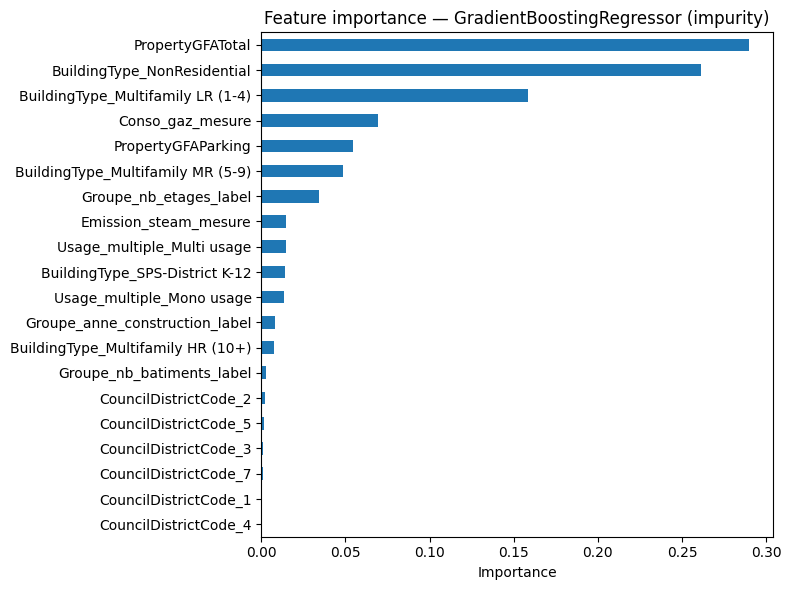

In [62]:
fi = pd.Series(best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top = fi.head(20)
plt.figure(figsize=(8,6))
top.iloc[::-1].plot(kind="barh")
plt.title("Feature importance — GradientBoostingRegressor (impurity)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()